In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt # for making figures
from torch.utils.data import random_split
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(min(len(w) for w in words))
print(words[:8])

32033
15
2
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
chars = sorted(list(set(''.join(words))))
chars.insert(0, ".")

ctoi = { c:i for i, c in enumerate(chars)}
itoc = { i:c for i, c in enumerate(chars)}
vocab_size = len(chars)

print(ctoi)
print(vocab_size)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
27


In [4]:
train_wd, valid_wd, test_wd = random_split(words, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(420))

In [5]:
def pad(string, char, length):
    d = length - len(string)
    return string + char * d
    
pad("apple", ".", 10)

'apple.....'

In [6]:
[pad("."*3+w, ".", 15) for w in words][:10]

['...emma........',
 '...olivia......',
 '...ava.........',
 '...isabella....',
 '...sophia......',
 '...charlotte...',
 '...mia.........',
 '...amelia......',
 '...harper......',
 '...evelyn......']

In [7]:
kernel_size = 4

def char_idx(word):
    return [ctoi[c] for c in word]

def build_dataset(words):
    X = []
    Y = []
    
    for w in words:
        x = "." * kernel_size + w
        y = w + "."
        X.append(torch.tensor(char_idx(x)))
        Y.append(torch.tensor(char_idx(y)))

    return X, Y

train_x, train_y = build_dataset(train_wd)
valid_x, valid_y = build_dataset(valid_wd)

In [8]:
train_x[0], train_wd[0]

(tensor([ 0,  0,  0,  0, 10,  1, 25, 19,  5, 14]), 'jaysen')

In [9]:
class Transpose(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.T
    
    def string(self):
        return "Transpose"

In [10]:
class Permute(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.permute(self.dim)
    
    def string(self):
        return "Permute"

In [11]:
class Inspect(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        self.x = x
        return x

In [12]:
@torch.no_grad()
def eval_split():
    lossi = []
    for x, y in zip(valid_x, valid_y):
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        lossi.append(loss.item())
        
    return torch.tensor(lossi).mean()

In [13]:
embed_size = 10
hidden_size = 128

# input (batch, seq)
model = nn.Sequential(
    nn.Embedding(vocab_size, embed_size), # (seq, embed)
    Transpose(), # (embed, seq)
    
    # num of conv = kernel_size -1
    nn.Conv1d(in_channels=embed_size, out_channels=hidden_size, kernel_size=2), # (embed, seq)
    nn.Tanh(),
    
    nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=2), # (embed, seq)
    nn.Tanh(),
    
    nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=2), # (embed, seq)
    nn.Tanh(),

    Transpose(), # (seq, embed)
    nn.Linear(hidden_size, vocab_size)
)

for p in model.parameters():
    p.requires_grad = True
    
print(sum((p.nelement() for p in model.parameters())))

72233


In [14]:
import random

optimizer = torch.optim.Adam(model.parameters())
lossi = []

for _ in range(5):
    ds = list(zip(train_x, train_y))
    random.shuffle(ds)
    
    for x, y in ds:
        optimizer.zero_grad()
        
        logits = model(x)    
        loss = F.cross_entropy(logits, y)
        loss.backward()

        optimizer.step()
        lossi.append(loss.item())

        if len(lossi) % 10000 == 0:
            avg = torch.tensor(lossi[-10000:]).mean()
            print(f"{avg:.4f}")

2.2835
2.2349
2.1985
2.2375
2.2019
2.2157
2.1888
2.1841
2.2027
2.1787
2.1776
2.1748


In [15]:
valid_loss = eval_split()
print(f"train: {torch.tensor(lossi[-10000:]).mean():.4f}")
print(f"valid: {valid_loss:.4f}")

train: 2.1804
valid: 2.2034


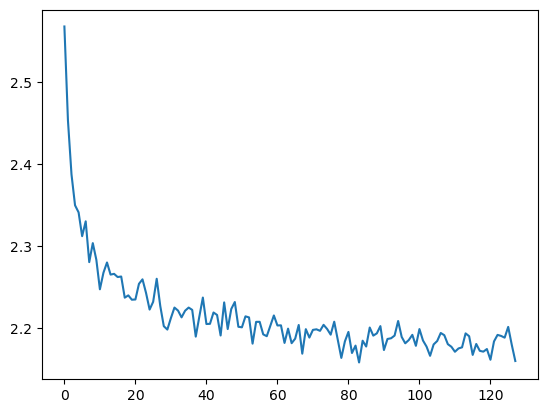

In [16]:
bucket = 1000
clip = len(lossi) - (len(lossi) % bucket)

l = torch.tensor(lossi[0:clip])
l = l.view(-1, bucket).mean(1)
plt.plot(l)

#### Log

Single example stocastic gradient
- train: 2.2232
- valid: 2.2155
  
Mini-batch gradient descent (embed_size: 16, hidden_size: 64)
- train: 2.0666
- valid: 2.1058

3 layer casual conv (kernel = 2, embed_size = 10, hidden_size = 128)
- train: 2.1842
- valid: 2.2098

In [19]:
for _ in range(10):
    sample = [0] * kernel_size

    while(True):
        ctx = sample[-kernel_size:] 
        ctx = torch.tensor(ctx)
        logits = model(ctx) # (1, 27)
        prob = F.softmax(logits, 1).view(-1)
        idx = torch.multinomial(prob, 1).item()
        sample.append(idx)

        if idx == 0 or len(sample) > 50:
            break

    word = "".join([itoc[idx] for idx in sample[kernel_size:-1]])
    print(word)

anayahn
shavy
anmarion
emai
shiya
loriell
wezie
sahyree
suvee
raeli
